# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from IPython.core.display import Image,display
import datetime
import warnings
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

## 0.2 Loading Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [3]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
443818,834,5,2014-05-30,7513,799,1,0,0,1,a,a,3470.0,3.0,2012.0,0,NaN,NaN,NaN


# 1.0 Descricao dos Dados

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [6]:
print( 'number of rows: {}'.format( df1.shape[0] ) )
print( 'number of cols: {}'.format( df1.shape[1] ) )

number of rows: 1017209
number of cols: 18


## 1.3 Data Types

In [7]:
df1[ 'date' ] = pd.to_datetime( df1[ 'date' ] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [8]:
# 3 formas de substituir NA
# 1. Jogar Fora
# 2. Substituir (fillna) ou com Machine Learning
# 3. Lógica de Negócio (descobrir na empresa o que gerou o NA e usar essa regra para recuperar os dados)

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [9]:
df1['competition_distance'].max()

75860.0

In [10]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
611137,903,2,2013-12-31,6217,574,1,0,0,1,d,c,7290.0,9.0,2014.0,0,NaN,NaN,NaN


In [11]:
# Tratando os Dados NA a partir da Lógica de Negócio

# competition_distance  
df1[ 'competition_distance' ] = df1[ 'competition_distance' ].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df1[ 'competition_open_since_month' ] = df1.apply( lambda x: x[ 'date' ].month if math.isnan( x[ 'competition_open_since_month' ] ) else x[ 'competition_open_since_month' ], axis=1 )

# competition_open_since_year 
df1[ 'competition_open_since_year' ] = df1.apply( lambda x: x[ 'date' ].year if math.isnan( x[ 'competition_open_since_year' ] ) else x[ 'competition_open_since_year' ], axis=1 )
                         
# promo2_since_week 
df1[ 'promo2_since_week' ] = df1.apply( lambda x: x[ 'date' ].week if math.isnan( x[ 'promo2_since_week' ] ) else x[ 'promo2_since_week' ], axis=1 )
   
# promo2_since_year 
df1[ 'promo2_since_year' ] = df1.apply( lambda x: x[ 'date' ].year if math.isnan( x[ 'promo2_since_year' ] ) else x[ 'promo2_since_year' ], axis=1 )

# promo_interval 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1[ 'promo_interval' ].fillna( 0, inplace=True )

df1[ 'month_map' ] = df1[ 'date' ].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x[ 'promo_interval' ] == 0 else 1 if x[ 'month_map' ] in x[ 'promo_interval' ].split( ',' ) else 0, axis=1 )


In [12]:
# não temos mais NA's
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [13]:
df1.sample(5).T

,629253,864139,513024,509424,601335
store,64,800,910,655,21
day_of_week,6,6,6,2,3
date,2013-12-14 00:00:00,2013-05-18 00:00:00,2014-03-29 00:00:00,2014-04-01 00:00:00,2014-01-08 00:00:00
sales,10937,5395,4224,10385,7197
customers,820,560,441,780,591
open,1,1,1,1,1
promo,0,0,0,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,d,d,d,c


## 1.6 Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
#mudando os tipos de float para int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')  
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics

In [17]:
#Estatística Descritiva serve para 2 coisas:
#1. Ganhar conhecimento de Negócio
#2. Detectar Erros e Anomalias

#Existem 2 grandes métricas na estatística Descritiva
#1. Tendência Central -> Média e Mediana resumem todos os dados em valores únicos
#2. Dispersão -> Variância, Min e Máx, Skew, Kurtosis e Desv.Padrao mostram o quão esparso estão os dados ao redor da média

In [18]:
#Precisamos separar os dados em variáveis numéricas e categóricas

#numéricas
num_attributes = df1.select_dtypes( include=[ 'int64', 'float64' ] )

#categoricas
cat_attributes = df1.select_dtypes( exclude=[ 'int64', 'float64', 'datetime64[ns]' ] )

cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
678934,0,a,a,"Jan,Apr,Jul,Oct",Oct
724668,0,d,c,0,Sep


## 1.7.1 Numerical Attributes

In [19]:
#tendencia central / central tendency ct
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#dispersao
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skw', 'kurtosis'  ] 

In [20]:
m

,attributes,min,max,range,mean,median,std,skw,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance'>

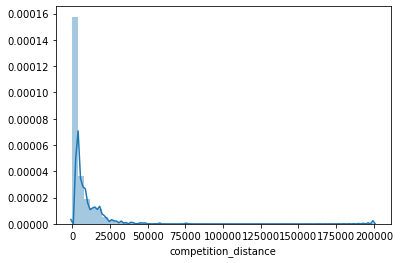

In [21]:
#competition distance tem um elevado skew positivo e kurtosis
#isso mostra que a maioria das lojas competidoras são próximas (distancia) e perto de zero

#media = mediana -> normal
sns.distplot( df1[ 'competition_distance' ] )

## 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

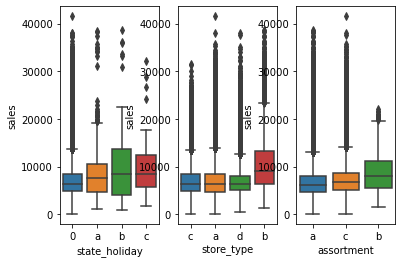

In [23]:
#filtragem
#como as variaveis categorigas são muito dispares, o boxplot fica disperso demais
#filtrando em state_holiday !=0 e sales > 0 reduz o tamanho do gráfico
aux1 = df1[ ( [ 'state_holiday' ] != 0 ) & ( df1[ 'sales' ] > 0 ) ]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0 Feature Engineering

In [24]:
df2 = df1.copy()

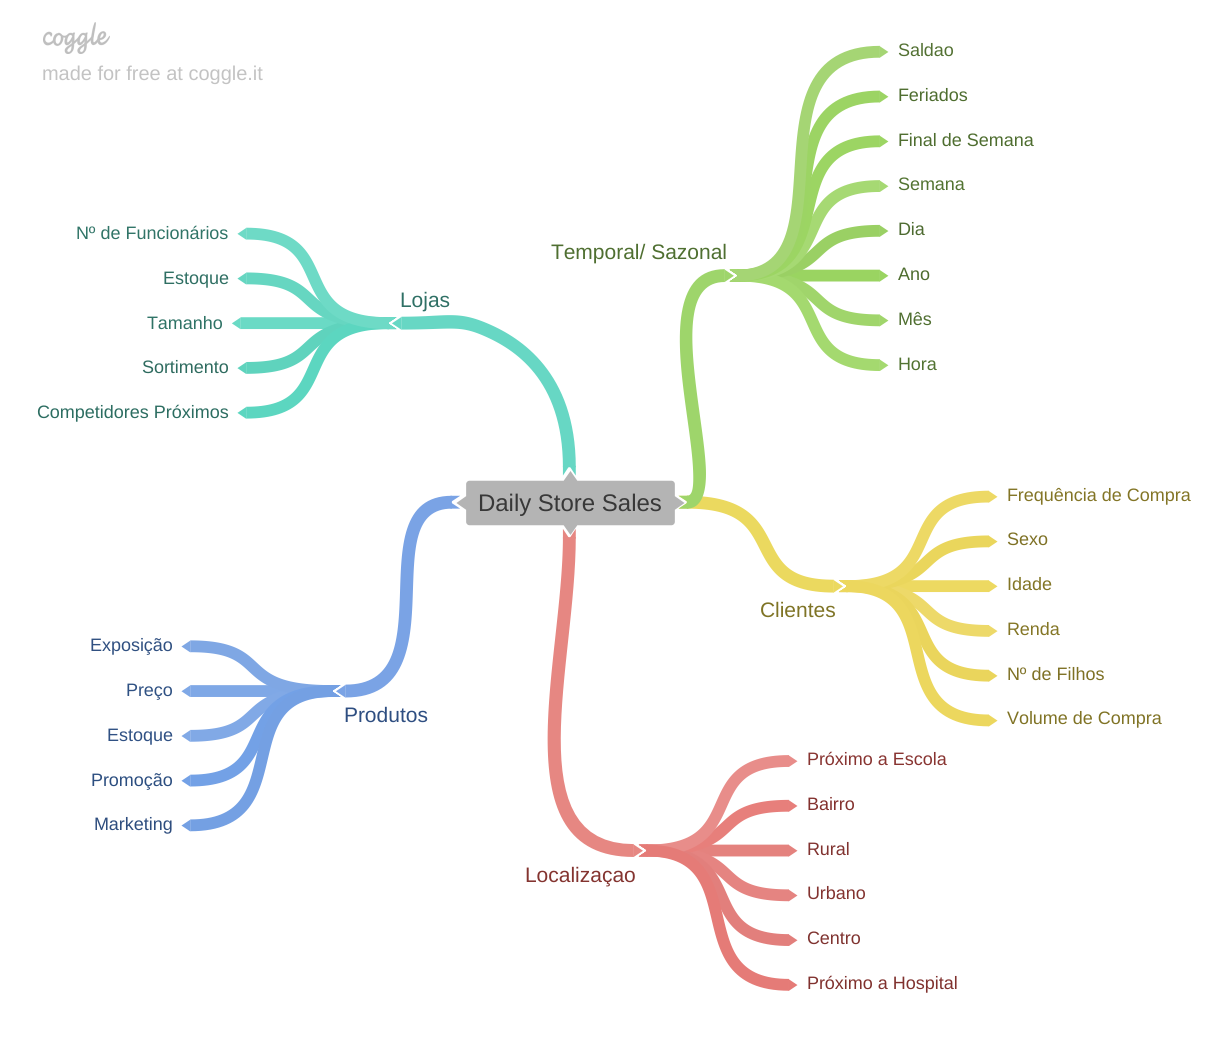

In [25]:
Image('img/mindmap_hypotesis.png')

## 2.1 Criacao das Hipoteses

In [26]:
df2 = df1.copy()

### 2.1.1 Hipoteses Lojas

**1.** Lojas com maior quadro de funcionários vendem/ ou deveriam vender mais

**2.** Lojas com maior estoque vendem/ ou deveriam vender mais

**3.** Lojas com maior porte vendem/ ou deveriam vender mais

**4.** Lojas com menor porte vendem/ ou deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais

### 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais

**2.** Lojas que expoem mais o produto nas vitrines deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais

**4.** Lojas que tem preços menores por mais tempo deveriam vender mais

### 2.1.3 Hipoteses Tempo

**1.** Lojas que entram mais em feriados deveriam vender menos

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais

**3.** Lojas que abrem nos finais de semana deveriam vender mais

## 2.2 Lista Final de Hipoteses (Prioridades)

#consigo fazer essas hipóteses aqui por que já tenho os dados no meu conjunto, as outras eu ainda não tenho

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas com promoçoes ativas a mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoçoes consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas que abrem nos primeiros 6 meses deveriam vender mais

**9.** Lojas que abrem nos finais de semana deveriam vender mais

**10.** Lojas deveriam vender mais ao longo dos anos

**11.** Lojas deveriam vender mais no segundo semestre do ano

**12.** Lojas deveriam vender mais depois do dia 10 de cada mes

**13.** Lojas deveriam vender menos aos finais de semana

**14.** Lojas deveriam vender menos durante os feriados escolares


## 2.3 Feature Engineering

In [27]:

# variáveis à derivar:

# year
df2[ 'year' ] = df2[ 'date' ].dt.year

# month 
df2[ 'month' ] = df2[ 'date' ].dt.month

# day
df2[ 'day' ] = df2[ 'date' ].dt.day

# week of year
df2[ 'week_of_year' ] = df2[ 'date' ].dt.weekofyear

# year week
df2[ 'year_week' ] = df2[ 'date' ].dt.strftime( '%Y-%W' )

# competition since
df2[ 'competition_since' ] = df2.apply( lambda x: datetime.datetime(year=x[ 'competition_open_since_year' ], month=x[ 'competition_open_since_month' ], day=1), axis=1 )
df2[ 'competition_time_month' ] = ( ( df2[ 'date' ] - df2[ 'competition_since' ] ) / 30 ).apply( lambda x: x.days).astype( int )

# promo since
df2[ 'promo_since' ] = df2[ 'promo2_since_year' ].astype( str ) + '-' + df2[ 'promo2_since_week' ].astype( str )
df2[ 'promo_since' ] = df2[ 'promo_since' ].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2[ 'promo_time_week' ] = ( ( df2[ 'date' ] - df2[ 'promo_since' ] ) / 7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2[ 'assortment' ] = df2[ 'assortment' ].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2[ 'state_holiday' ] = df2[ 'state_holiday' ].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

df2.head().T


,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variaveis

In [28]:
df3 = df2.copy()

## 3.1 Filtragem de Linhas

In [29]:
df3 = df3[ ( df3[ 'open' ] != 0 ) & ( df3[ 'sales' ] > 0 ) ]

## 3.2 Selecao de Colunas

In [30]:
drop_cols = [ 'customers', 'open', 'promo_interval', 'month_map' ]
df3 = df3.drop( drop_cols, axis=1 )

In [31]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Analise Exploratoria de Dados

In [32]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

<AxesSubplot:xlabel='sales'>

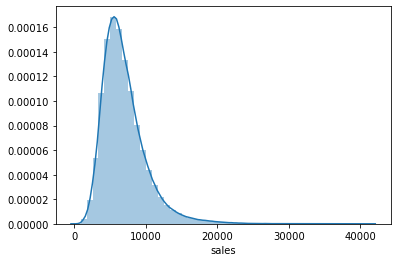

In [33]:
sns.distplot( df4[ 'sales' ] )

### 4.1.2 Numerical Variable

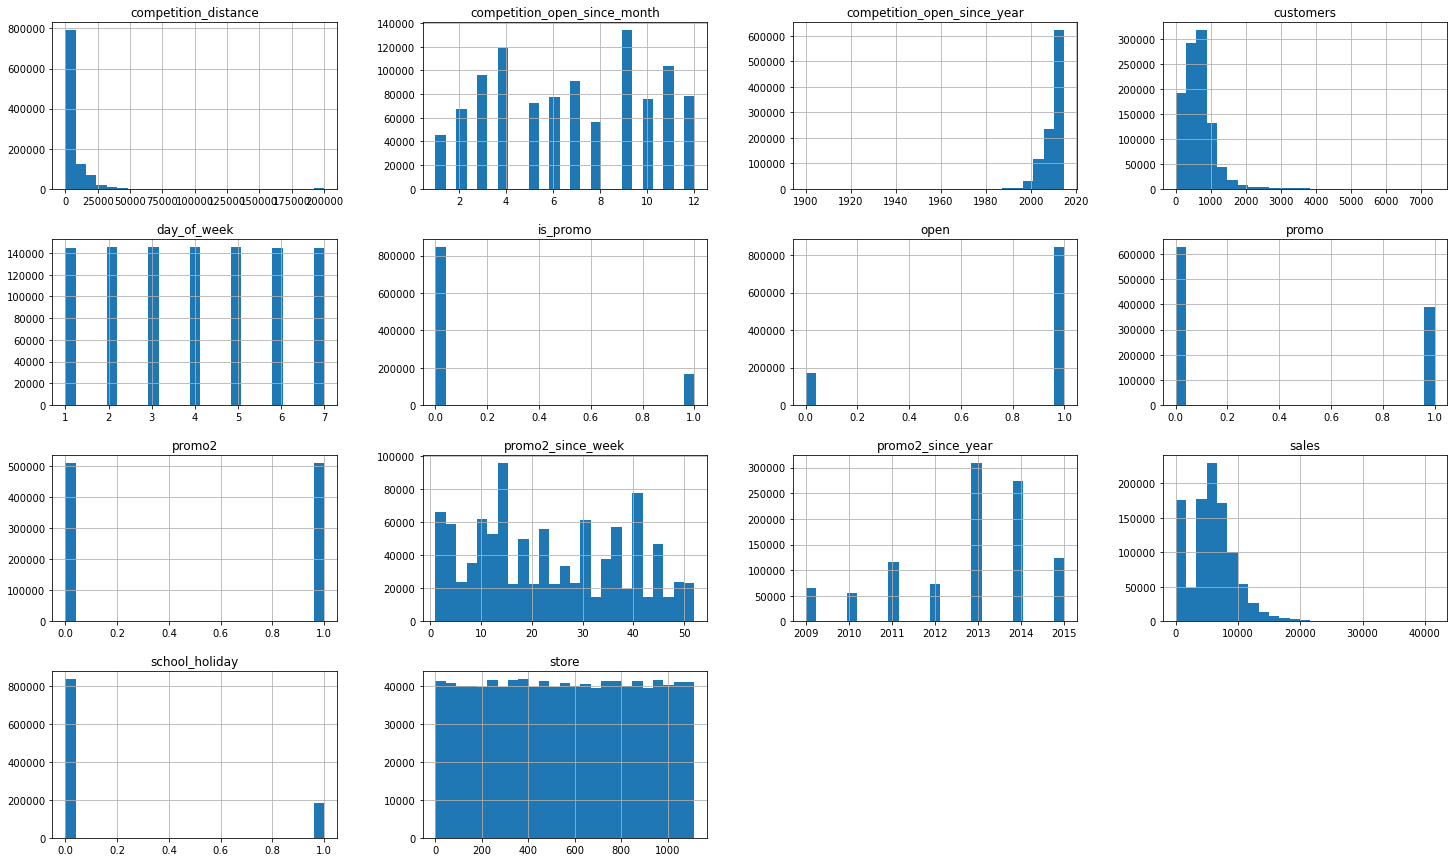

In [34]:
num_attributes.hist( bins=25, figsize=(25,15) );

### 4.1.3 Categorical Variable

In [35]:
df4[ 'assortment' ].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:>

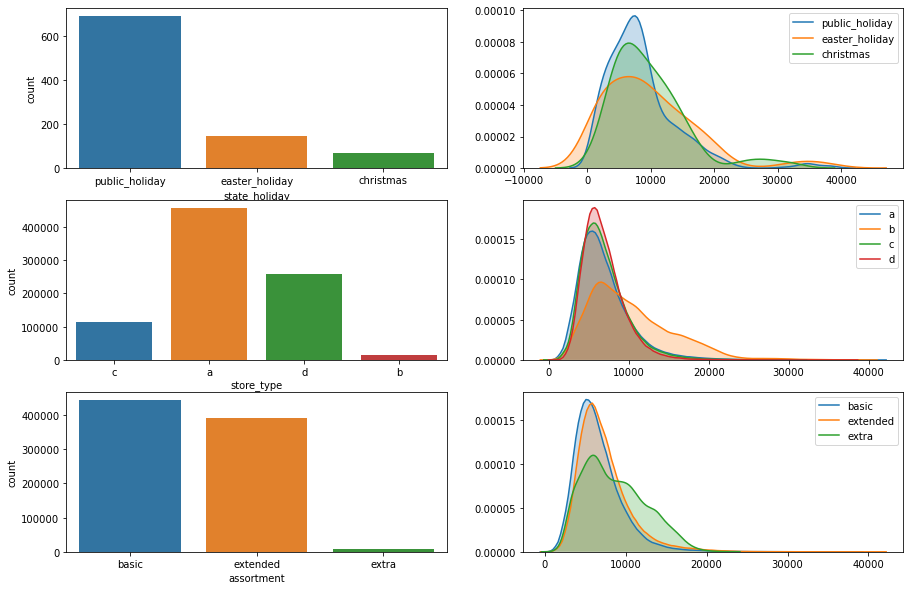

In [36]:
# state_holiday
f = plt.figure( figsize=(15,10) )

f.add_subplot( 321 )
a = df4[ df4[ 'state_holiday' ] != 'regular_day' ]
sns.countplot( a[ 'state_holiday' ] )

f.add_subplot( 322 )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'public_holiday' ]['sales'], label='public_holiday', shade=True  )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'easter_holiday' ]['sales'], label='easter_holiday', shade=True  )
sns.kdeplot( df4[ df4[ 'state_holiday' ] == 'christmas' ]['sales'], label='christmas', shade=True  )

# store_type

f.add_subplot( 323 )
sns.countplot( df4[ 'store_type' ] )

f.add_subplot( 324 )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'a' ]['sales'], label='a', shade=True  )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'b' ]['sales'], label='b', shade=True  )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'c' ]['sales'], label='c', shade=True  )
sns.kdeplot( df4[ df4[ 'store_type' ] == 'd' ]['sales'], label='d', shade=True  )

# assortment
f.add_subplot( 325 )
sns.countplot( df4[ 'assortment' ] )

f.add_subplot( 326 )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'basic' ]['sales'], label='basic', shade=True  )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'extended' ]['sales'], label='extended', shade=True  )
sns.kdeplot( df4[ df4[ 'assortment' ] == 'extra' ]['sales'], label='extra', shade=True  )

## 4.2 Analise Bivariada

#### H1. Lojas com maior sortimento deveriam vender mais
***Falsa*** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

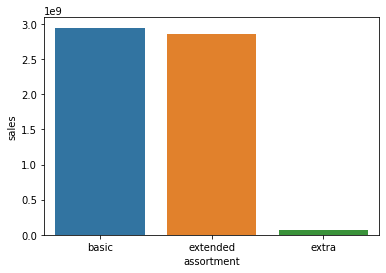

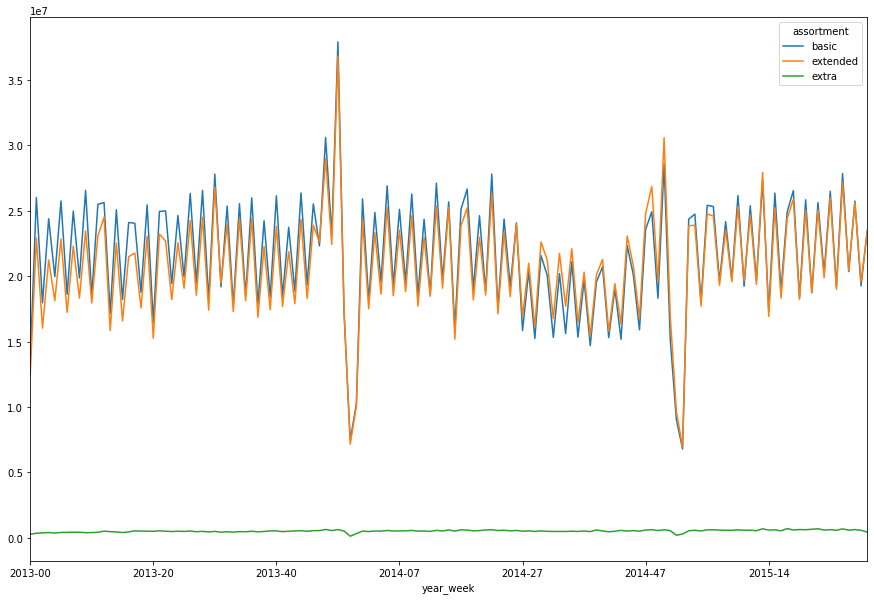

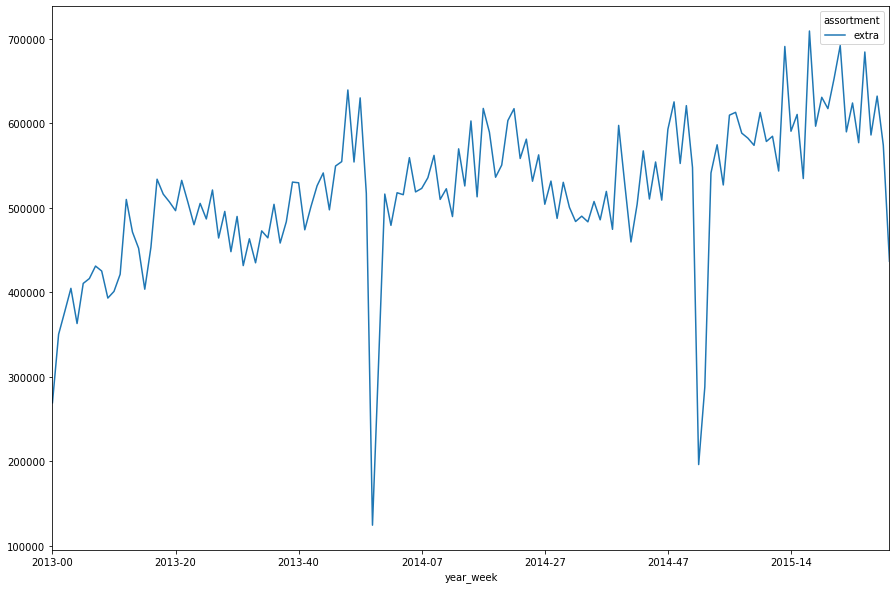

In [37]:
aux1 = df4[ [ 'assortment', 'sales' ] ].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[ [ 'year_week', 'assortment', 'sales' ] ].groupby( ['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(15,10))

aux3 = aux2[ aux2[ 'assortment' ] == 'extra' ]
aux3.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(15,10))

#### H2. Lojas com competidores mais próximos deveriam vender menos
***Falsa*** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS

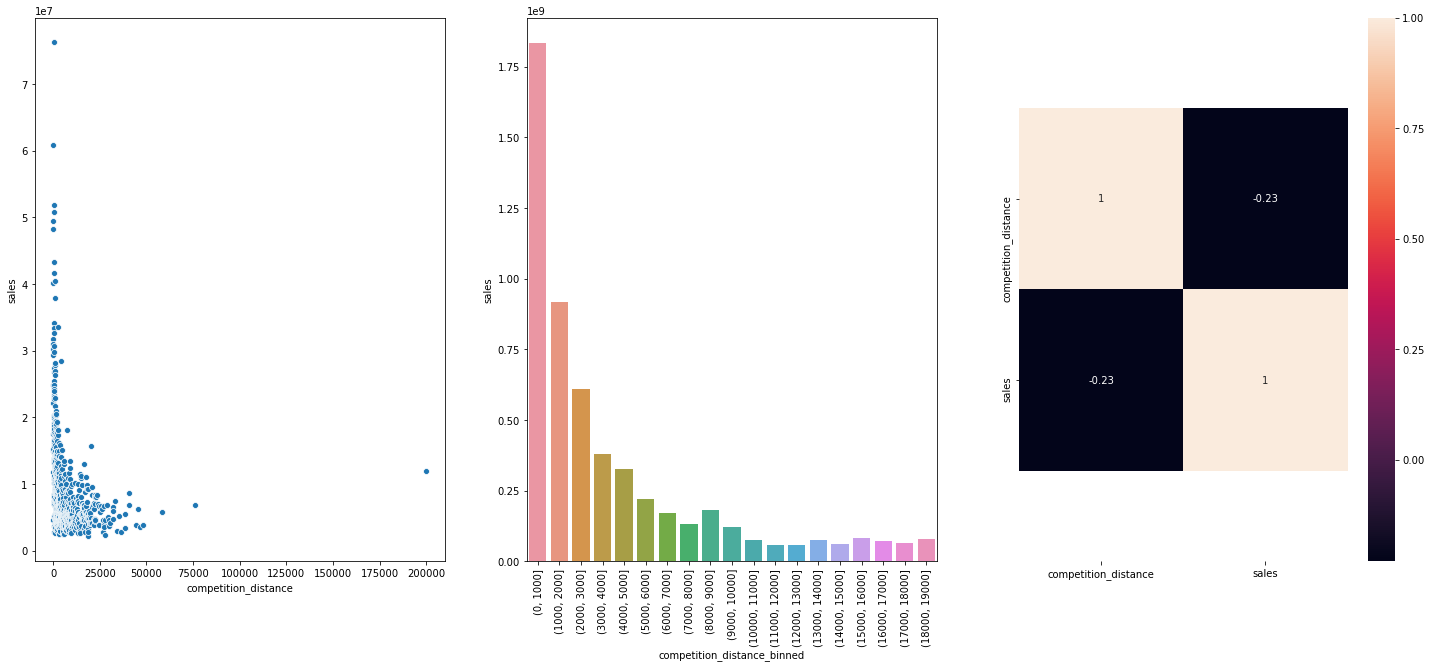

In [38]:
aux1 = df4[ [ 'competition_distance', 'sales' ] ].groupby( 'competition_distance' ).sum().reset_index()

f = plt.figure( figsize=(25,10) )
f.add_subplot( 131 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1);

bins = list( np.arange( 0, 20000, 1000 ) )

aux1[ 'competition_distance_binned' ] = pd.cut( aux1[ 'competition_distance'], bins=bins )
aux2 = aux1[ [ 'competition_distance_binned', 'sales' ] ].groupby( 'competition_distance_binned' ).sum().reset_index()

f.add_subplot( 132 )
#plt.figure( figsize=(30, 10) )
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90 )

f.add_subplot( 133 )
x = sns.heatmap( aux1.corr( 'pearson' ), annot=True )
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

#### H3. Lojas com competidores a mais tempo deveriam vender mais
***Falsa*** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

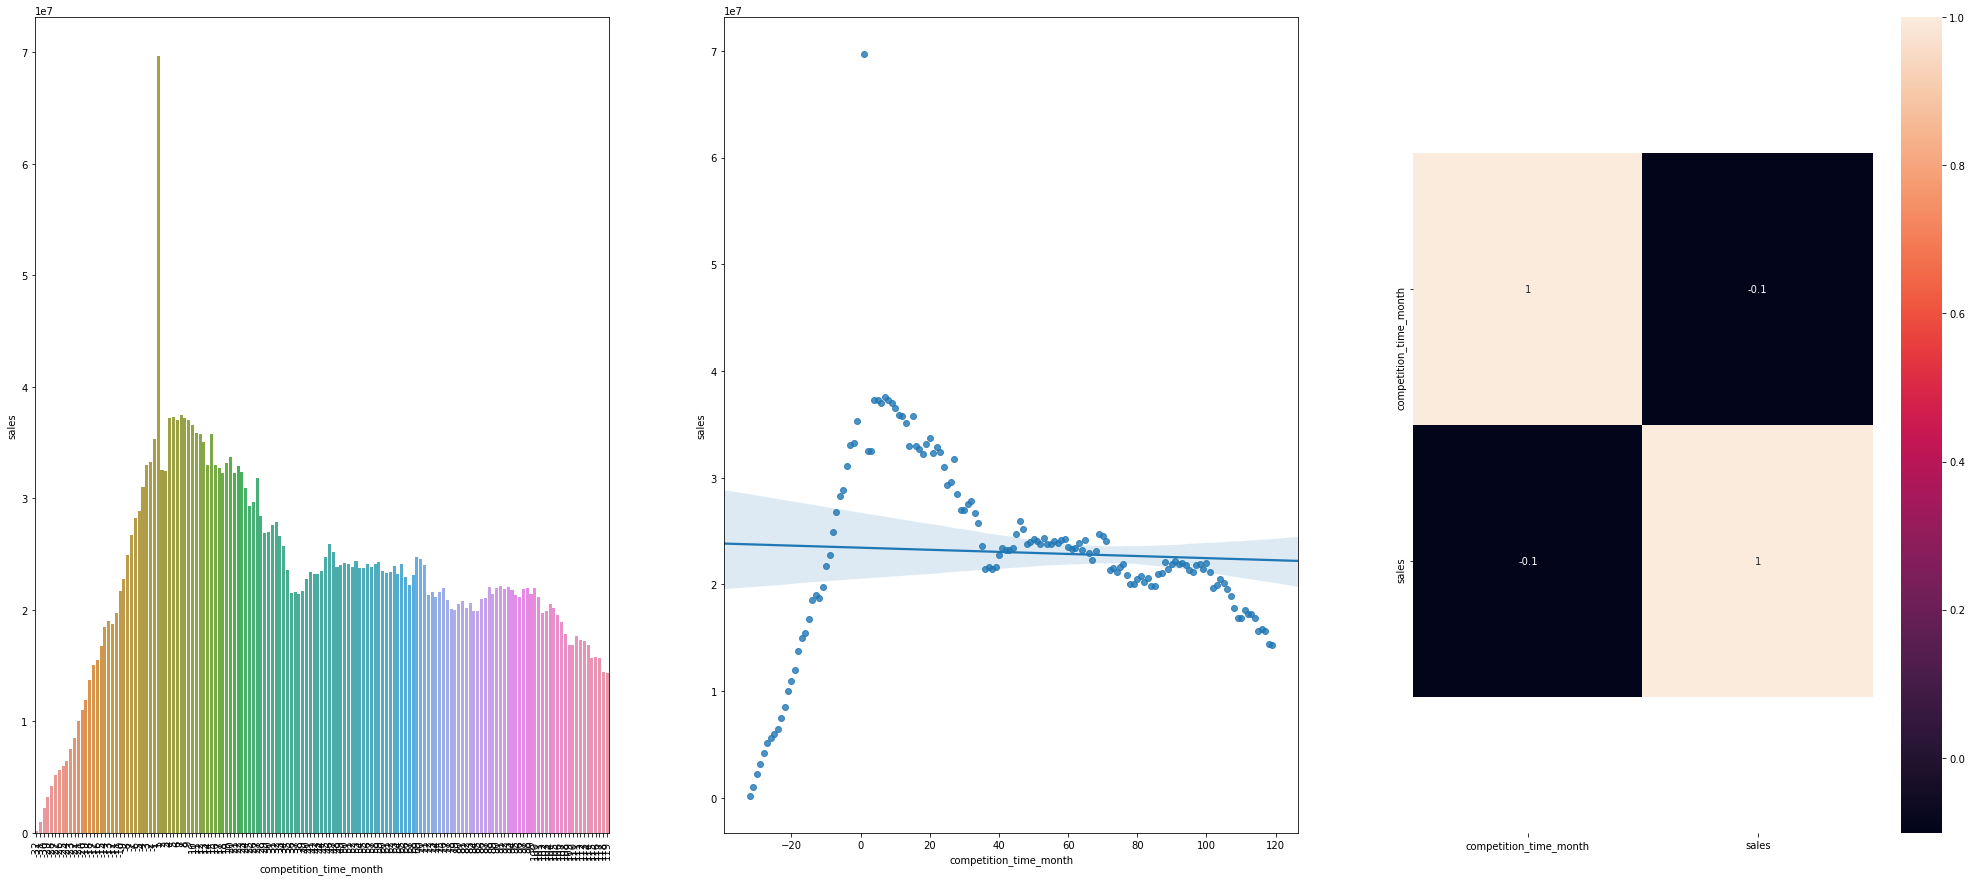

In [39]:
aux1 = df4[ [ 'competition_time_month', 'sales' ] ].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[ ( aux1[ 'competition_time_month' ] < 120 ) & ( aux1[ 'competition_time_month' ] != 0 ) ]

plt.figure( figsize=( 35, 15) )
plt.subplot( 1, 3, 1)
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3 ,3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True )
bottom, top = x.get_ylim( )
x.set_ylim( bottom+0.5, top-0.5);

#### H4. Lojas com promoçoes ativas a mais tempo deveriam vender mais
***Falsa*** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção

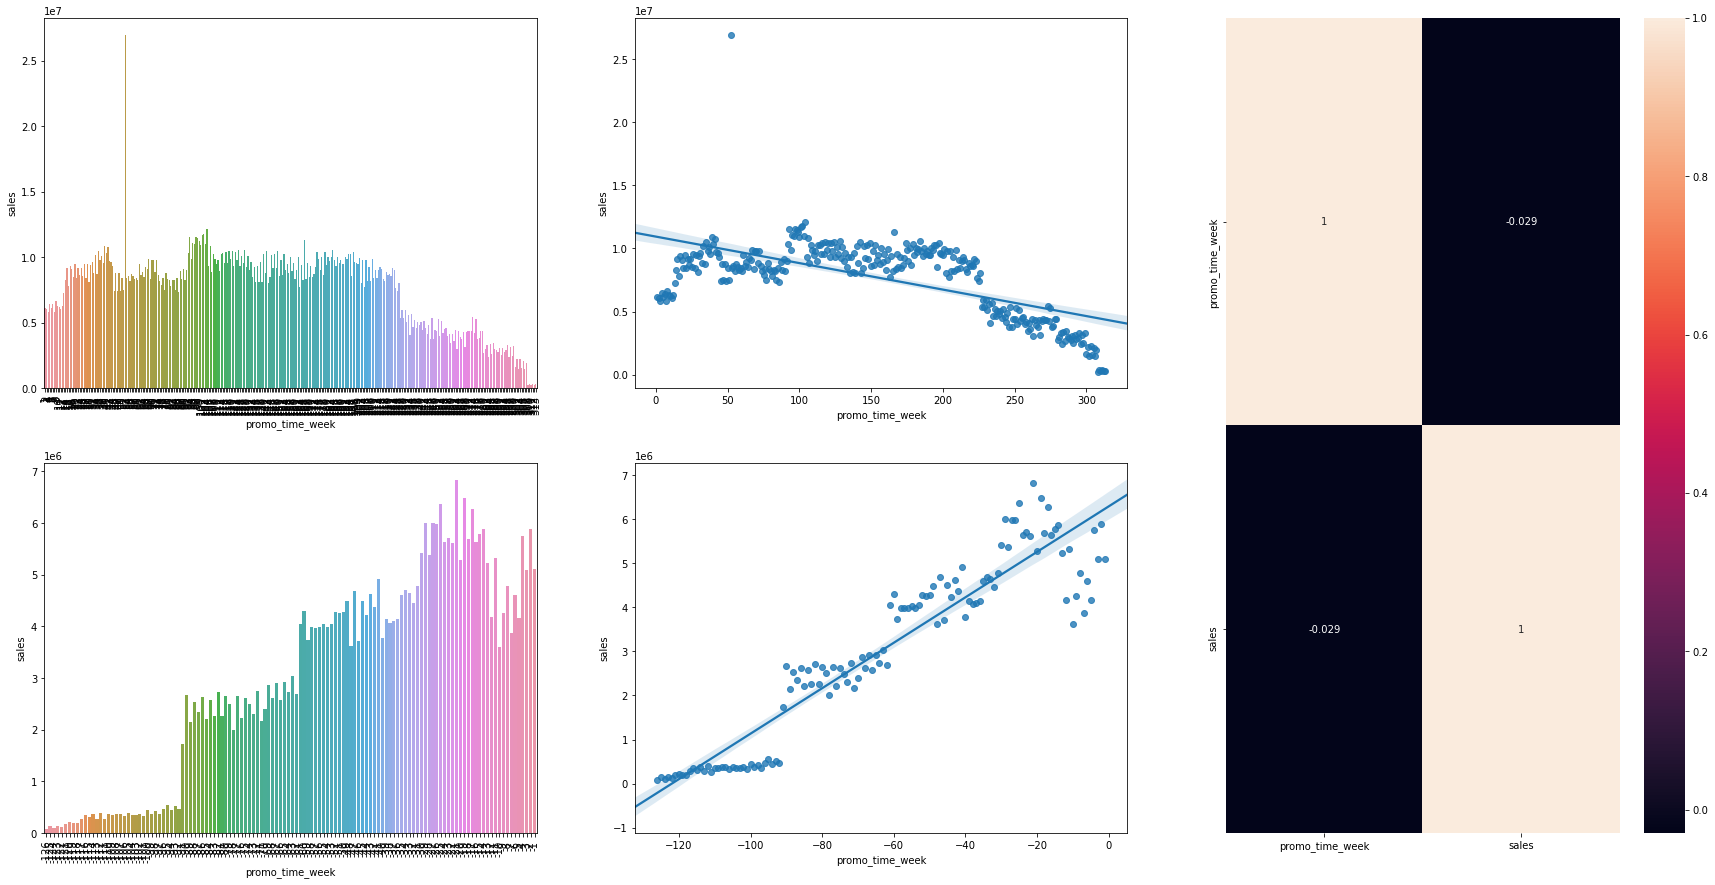

In [40]:
aux1 = df4[[ 'promo_time_week', 'sales' ]].groupby( 'promo_time_week' ).sum().reset_index()

grid = plt.GridSpec( 2, 3 )

plt.figure( figsize=( 30,15 ) )

plt.subplot( grid[0,0] )
aux2 = aux1[ aux1[ 'promo_time_week' ] > 0 ] #promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[ aux1[ 'promo_time_week' ] < 0 ] #promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### H5. <s> Lojas com mais dias de promoção deveriam vender mais </s>

#### H6. Lojas com mais promoçoes consecutivas deveriam vender mais
***Falsa*** Lojas com mais promoções consecutivas vendem menos

In [41]:
df4[ [ 'promo', 'promo2', 'sales' ] ].groupby( [ 'promo', 'promo2' ] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


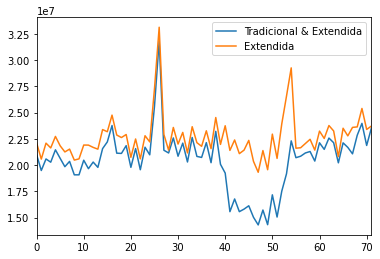

In [42]:
aux1 = df4[ ( df4[ 'promo' ] == 1 ) & ( df4[ 'promo2' ] == 1 ) ][[ 'year_week', 'sales' ]].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot();

aux2 = df4[ ( df4[ 'promo' ] == 1 ) & ( df4[ 'promo2' ] == 0 ) ][[ 'year_week', 'sales' ]].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax );

ax.legend( labels=[ 'Tradicional & Extendida', 'Extendida' ] );

#### H7. Lojas abertas durante o feriado de Natal deveriam vender mais
***Falsa*** Lojas abertas durante o feriado de Natal vendem menos

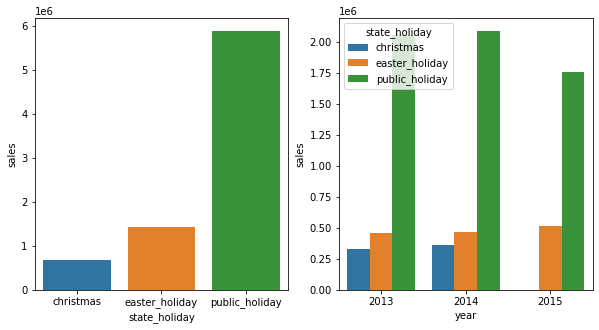

In [43]:
plt.figure( figsize=(10,5) )
plt.subplot( 1, 2, 1 )
aux = df4[ df4[ 'state_holiday' ] != 'regular_day' ]
aux1 = aux[[ 'state_holiday', 'sales' ]].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[[ 'year', 'state_holiday', 'sales']].groupby( [ 'year', 'state_holiday' ] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

#### H8. Lojas deveriam vender mais ao longo dos anos
***Falsa*** Lojas vendem menos ao longo dos anos


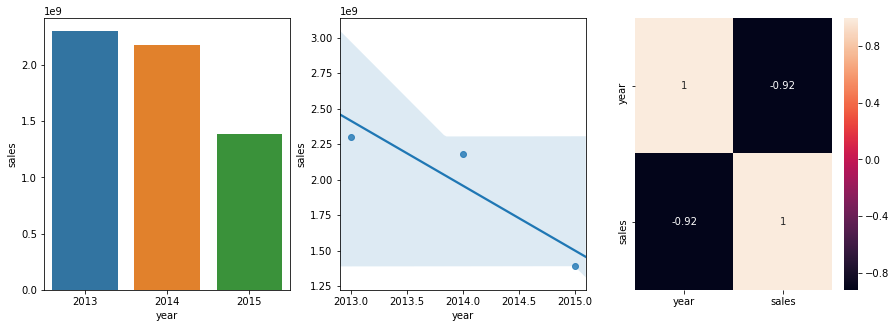

In [48]:
plt.figure( figsize=(15,5) )
plt.subplot( 1, 3, 1 )
aux1 = df4[[ 'year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot(x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### H11. Lojas deveriam vender mais no segundo semestre do ano
***Falsa*** Lojas vendem menos no segundo semestre do ano

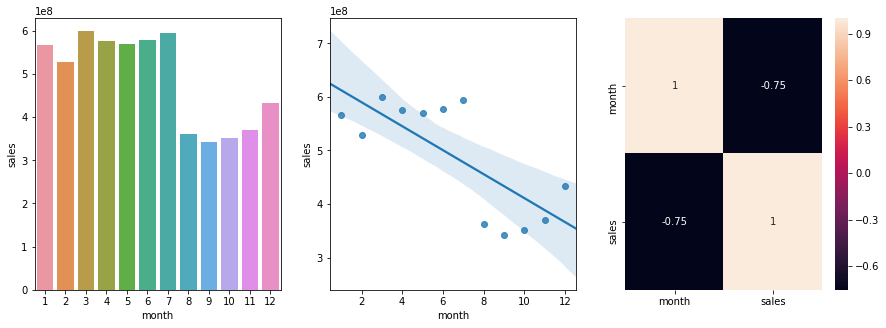

In [49]:
plt.figure( figsize=(15,5) )
plt.subplot( 1, 3, 1 )
aux1 = df4[[ 'month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot(x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### H12. Lojas deveriam vender mais depois do dia 10 de cada mes
***Verdadeira*** Lojas vendem mais depois do dia 10 de cada mês

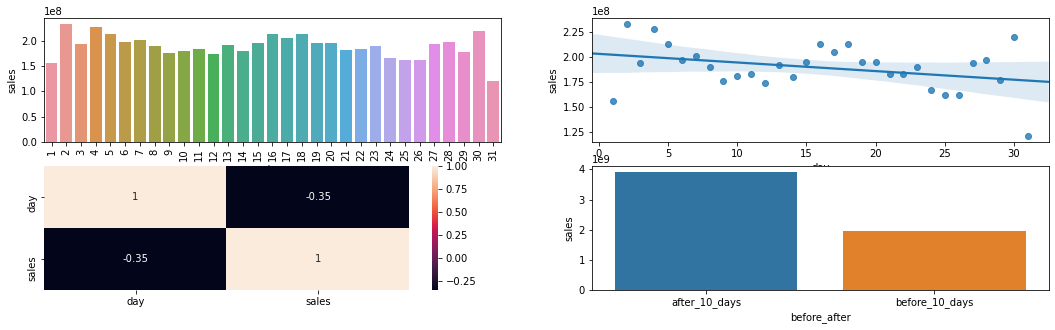

In [57]:
plt.figure( figsize=(18,5) )
plt.subplot( 2, 2, 1 )
aux1 = df4[[ 'day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1 );
plt.xticks( rotation=90 )

plt.subplot( 2, 2, 2 )
sns.regplot(x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.subplot( 2, 2, 4 )
aux1[ 'before_after' ] = aux1[ 'day' ].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[[ 'before_after', 'sales' ]].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );

#### H13. Lojas deveriam vender menos aos finais de semana
***Verdadeira*** Lojas vendem menos aos fins de semana

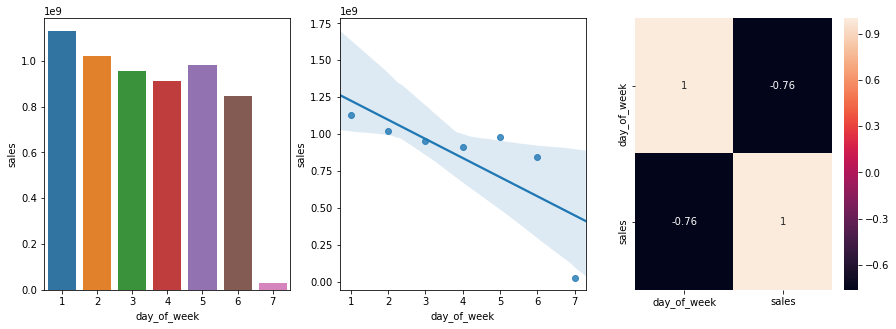

In [58]:
plt.figure( figsize=(15,5) )
plt.subplot( 1, 3, 1 )
aux1 = df4[[ 'day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot(x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### H14. Lojas deveriam vender menos durante os feriados escolares
***Verdadeira*** Lojas vendem menos durante os feriados escolares, exceto durante os meses de julho e agosto.

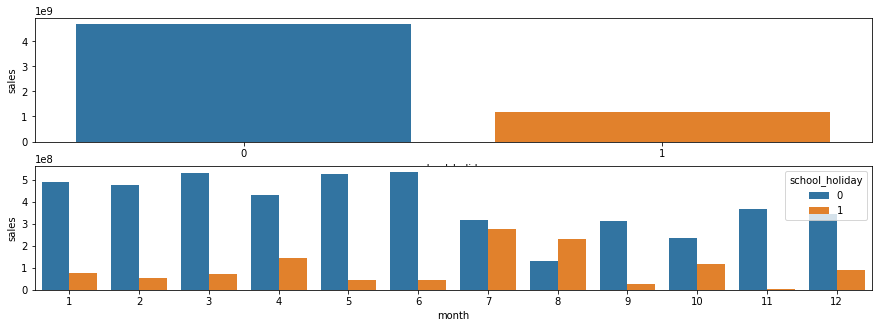

In [61]:
plt.figure( figsize=(15,5) )
plt.subplot( 2, 1, 1 )
aux1 = df4[[ 'school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1 );

plt.subplot( 2, 1, 2 )
aux2 = df4[[ 'month', 'school_holiday', 'sales' ]].groupby([ 'month', 'school_holiday' ]).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2);

## 4.3 Analise Multivariada